In [1]:
# The notebook contantains methodes for bin files reading and visualizing (IMU data)

In [1]:
from struct import *
import pandas as pd
import os.path as path
%matplotlib inline
import matplotlib.pyplot as plt

In [24]:
def load_data(file_name, sense_type):
    # sense_type: 'ACR', 'ACN', 'GYR', 'GYN', 'HUN', 'BAN', 'HTN', 'PTN', 'BTN'
    # If sense_type is in ['ACR', 'ACN', 'GYR', 'GYN'] then x, y, and z component are available and sense_type has 
    # additional last symbol 'C', otherwise the last symbol is 'N'. For example, 'ACRC' or 'BTNN'
    # The data field's mask is: 'SENSE_TYPE[s]'+'C[s]'+'x_value[f]'+'y_value[f]'+'z_value[f]'+'Time[f]' 
    # or 'SENSE_TYPE[s]'+'N[s]'+'value[f]'+'Time[f]'.

    # open and read data
    f = open(file_name, 'rb')
    data = f.read()
    f.close()
    
    
    # parse data fields
    position = 0
    counter = 0
    fields_found = {}
    triple_fields = ['ACRC', 'ACNC', 'GYRC', 'GYNC']
    single_fields = ['HUNN', 'BANN', 'HTNN', 'PTNN', 'BTNN', 'IMAG']

    
    
    if sense_type + 'C' in triple_fields:
        columns = ['x', 'y', 'z', 'time']
    elif sense_type + 'N' in single_fields or sense_type == 'IMAG':
        columns = ['value', 'time']
    else:
        print 'Your provided sense type is not recognized!'
        return None
    
    value_series = []
    
    while len(data) > 0:
        if position + 4 > len (data):
            break
            
        data_pos = data[position:position + 4]
        if data_pos in triple_fields:               
            # read triple component
            if data_pos[:-1] == sense_type:
                unpack_data = data[position + 4: position + 4 + 12 + 8]
                values = unpack('<fffd', unpack_data)
                value_series.append(values)
                counter += 1
            
        elif data_pos in single_fields:
            # read single component
            if data_pos[:-1] == sense_type and sense_type != 'IMAG':
                unpack_data = data[position + 4: position + 4 + 4 + 4]
                values = unpack('<ff', unpack_data)
                value_series.append(values)
                counter += 1
            elif sense_type == 'IMAG' and data_pos == sense_type:
                unpack_data = data[position + 4: position + 4 + 4 + 8]
                values = unpack('<Id', unpack_data)
                value_series.append(values)
                counter += 1                
        
        # count data fields
        if (data_pos in triple_fields) or (data_pos in single_fields):
            if fields_found.has_key(data_pos):
                fields_found[data_pos] = fields_found[data_pos] + 1
            else:
                fields_found[data_pos] = 1
                
        # shift reading position
        position += 1
    
    data_series = pd.DataFrame(value_series, columns=columns)
    
    # get detected fields info
    for key in fields_found.keys():
        print "For {:s} readed {:d} records".format(key, fields_found[key])
    
    return data_series


In [43]:
sense_data = load_data('/home/sholc/optic_env/sources/hdeer/data/dump_000016.bin', 'HTN')
print sense_data.shape
print sense_data.tail(10)


For BTNN readed 5014 records
For GYRC readed 4969 records
For ACRC readed 4970 records
For IMAG readed 8 records
For HUNN readed 5024 records
For HTNN readed 5015 records
(5015, 2)
          value          time
5005  33.985832  1.503677e+09
5006  33.985832  1.503677e+09
5007  33.985832  1.503677e+09
5008  33.949310  1.503677e+09
5009  33.949310  1.503677e+09
5010  33.949310  1.503677e+09
5011  34.040619  1.503677e+09
5012  34.040619  1.503677e+09
5013  34.040619  1.503677e+09
5014  34.004093  1.503677e+09


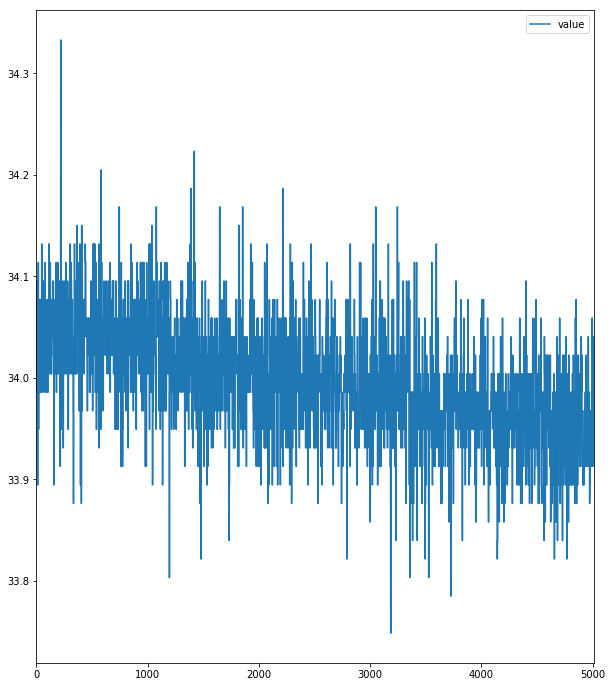

In [44]:
sense_data.plot(kind='line', y=['value'], figsize=(10, 12))